In [1]:
import cvxpy as cp
import numpy as np
import numpy.random as npr
import torch
import pandas as pd
import lro
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"]

# Learned Uncertainty Sets

### Formulating the uncertainty set

We now formulate the uncertainty set slightly differently, where data and a loss function is passed as parameters instead of the uncertainty set parameters. The new parameters for the uncertainty set, $A$ and $b$, will be trained through differentiable optimization. 

Box uncertainty: $ \{ u \mid\| Au - b \|_\infty \leq 1 \}$ 
- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set. 

Ellipsoidal uncertainty: $\{u \mid \| Au - b \|_p \leq 1 \}$ 
- $p$ : integer, optional  
  * Order of the norm. Default 2.
- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set. 


Budget uncertainty: 
1. train the box portion only:  $\{u \mid \| Au - b \|_\infty \leq 1, \| u \|_1 \leq \rho_2\}$ 
2. train the 1-norm portion only: $\{u \mid \| u \|_\infty \leq \rho_1, \| Au - b \|_1 \leq 1\}$ 
- train_box: boolean, optional
  * If True, train the box portion only. Default True. 
- $\rho_1$ : float, optional
  * Box scaling. Default 1.0.
- $\rho_2$ : float, optional
  * 1-norm scaling. Default 1.0.
- data : np.array  
  * An array of uncertainty realizations, where each row is one realization.
- loss : function
  * The loss function used to train the uncertainty set. 


### Formulating the loss function

The loss function passed into the uncertainty set must be a function that returns torch tensors with gradient information. The function must take in as inputs all the variables defined in the Robust Problem, as well as the data used to evaluate the loss. There may also be other inputs to the function, depending on the type of loss.  
- Violation loss  
  * inputs: 
    * *vars: all the variables of the Robust Problem.
    * data: np.array.
    * lmbda: float, the scale for the constraint violations.
  * outputs:
    * the violation loss as a torch tensor: the Robust Problem's objective function + the sum of constraint violations, scaled by lmbda.
    * the Robust Problem's objective function as a torch tensor.

### Training the uncertainty set

To train the uncertainty set, after setting up the robust problem, call `problem.train()`, with parameters specified below:

* eps: boolean, optional  
  * If True, train only $\epsilon$, where $A = \epsilon I, b = \epsilon \bar{d}$, where $\bar{d}$ is the centroid of the training data. Default False. 
* step: integer, optional  
  * The total number of gradient steps performed. Default 45.
* lr: float, optional
  * The learning rate of gradient descent. Default 0.01. 
* momentum: float between 0 and 1, optional  
  * The momentum for gradient descent. Default 0.8.
* optimizer: str, optional  
  * The optimizer to use tor the descent algorithm. Default "SGD".
* initeps: float, optional
  * The $\epsilon$ to initialize $A$ and $b$, if passed. If not passed, $A$ will be initialized as the inverse square root of the covariance of the data, and $b$ will be initialized as $\bar{d}$.

The function will output a pandas DataFrame, with a row for each iteration. The columns are:
* "step": integer  
  * The iteration number
* "Opt_val": float  
  * The objective value of the Robust Problem
* "Loss_val": float  
  * The value of the loss function applied to the training data
* "Eval_val": float  
  * The value of the loss function applied to the evaluation data
* "A_norm": float  
  * When eps = False, the 2-norm of the $A$ matrix. When eps = True, the $\epsilon$ value.

#### Simple Portfolio Example

Consider the simple portfolio problem where we want to select a portfolio of stocks that maximizes returns. The Robust Problem is formulated as
$$
\begin{array}{ll}
\text{minimize} & \tau\\
\text{subject to}  & -u^Tx \leq  \tau\\
& \mathbf{1}^Tx = 1, x \geq 0,
\end{array}
$$
where $u$ is the uncertain parameter. 

We train an ellipsoidal uncertainty set with $p = 2$, and consider the violation loss $\tau + \lambda(-u^Tx - \tau)$, where $\lambda = 1$ is the scaling for the sum of violations. 

In [4]:
# The violation loss function, in torch tensors
def violation_loss(t_soln, x_soln, data, lmbda=1):
    return t_soln + lmbda * torch.mean(
        torch.maximum(-data @ x_soln - t_soln, torch.tensor(0., requires_grad=True))), t_soln

In [5]:
# Setup the problem data
torch.seed()
sp500 = pd.read_csv('stock_data/prices_sp500.csv').to_numpy()
num_stocks = 100
num_rets = 500
npr.seed(1)
stock_idxs = np.random.choice(sp500.shape[1], num_stocks, replace=False)
sp_prices = sp500[:num_rets+1, stock_idxs]
sp_rets = (sp_prices[1:, :] - sp_prices[:-1, :])/sp_prices[1:, :]
sp_rets = sp_rets + 0.05

In [6]:
def normal_returns(m, N):
    R = np.vstack([np.random.normal(
        i*0.03, np.sqrt((0.02**2+(i*0.025)**2)), N) for i in range(1, m+1)])
    return (R.transpose())
def normal_returns1(m, N):
    R = np.vstack([np.random.normal(
        i*0.05, np.sqrt((0.01**2+(i*0.035)**2)), N) for i in range(1, m+1)])
    return (R.transpose())
d1 = normal_returns(100,250)
d2 = normal_returns1(100,250)
data = np.concatenate((d1,d2))

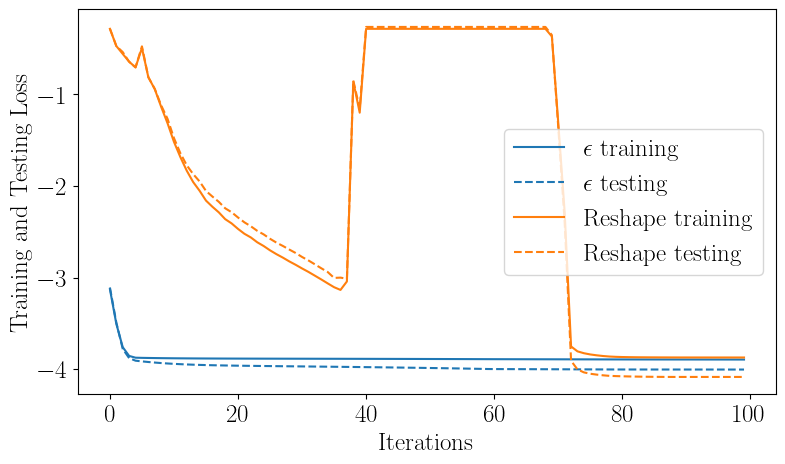

In [9]:
# Formulate the uncertainty set and uncertain parameter
unc_set = lro.Ellipsoidal(data=data, loss=violation_loss)
u = lro.UncertainParameter(num_stocks, uncertainty_set=unc_set)

# Formulate the Robust Problem
x = cp.Variable(num_stocks)
t = cp.Variable()

objective = cp.Minimize(t)
cons = [-u @ x <= t]
cons += [cp.sum(x) == 1, x >= 0]

prob_robust = lro.RobustProblem(objective, cons)

# Train only epsilon
df = prob_robust.train(eps=True, lr=0.1, step=100, momentum = 0.8, optimizer = "SGD", initeps = 1)

# Train A and b
df1= prob_robust.train(lr=0.4, step=100, momentum = 0.8, optimizer = "SGD")

# Grid search epsilno
dfgrid= prob_robust.grid(epslst = np.linspace(0.1, 5, 20))

# Plot results
df.to_csv('df_eps.csv')
df1.to_csv('df_R.csv')
dfgrid.to_csv('df_grid.csv')
plt.figure(figsize=(9, 5))
plt.plot(df['step'], df['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
plt.plot(df['step'], df['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
plt.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training")
plt.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Training and Testing Loss")
plt.savefig("plot.pdf")


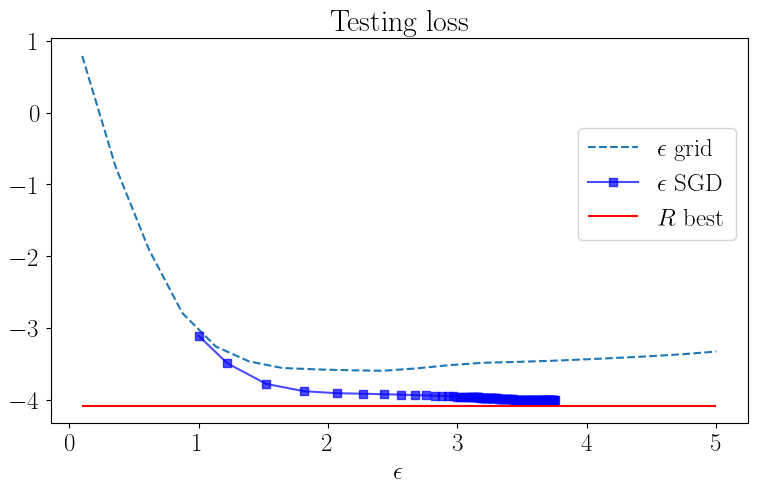

In [12]:
plt.figure(figsize=(9, 5))

styles = ["s",'o',"^","v","<",">","o",'s',"^","v","<",">"]
j=0
plt.plot(dfgrid["Eps"], dfgrid["Eval_val"], color = colors[j], linestyle='--',label="$\epsilon$ grid")
plt.plot(df["A_norm"],df["Eval_val"], linestyle='-', marker=styles[j], color = "blue", label="$\epsilon$ SGD",alpha = 0.7)
plt.hlines( xmin = 0.1, xmax = 5, y = np.min(df1["Eval_val"]), label = "$R$ best", color= "red")
    
plt.xlabel("$\epsilon$")
plt.title("Testing loss")
plt.legend(bbox_to_anchor=(1, 0.8))
plt.savefig("loss_compare.pdf")
plt.show()

In [13]:
df

,step,Opt_val,Eval_val,Loss_val,A_norm
0,0,-3.497303,-3.109004,-3.1269,1.0
1,1,-4.401766,-3.491702,-3.50553,1.2209296
2,2,-5.628721,-3.779345,-3.760773,1.522933
3,3,-6.804139,-3.880533,-3.856316,1.8150833
4,4,-7.805257,-3.90838,-3.875616,2.0661862
...,...,...,...,...,...
95,95,-14.379596,-4.005046,-3.895698,3.732837
96,96,-14.40106,-4.005083,-3.895758,3.738286
97,97,-14.422573,-4.005121,-3.895819,3.7437472
98,98,-14.44415,-4.005157,-3.89588,3.7492247
